In [9]:
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.signal as signal
import pandas as pd
#import pywt


### EMG isometrico

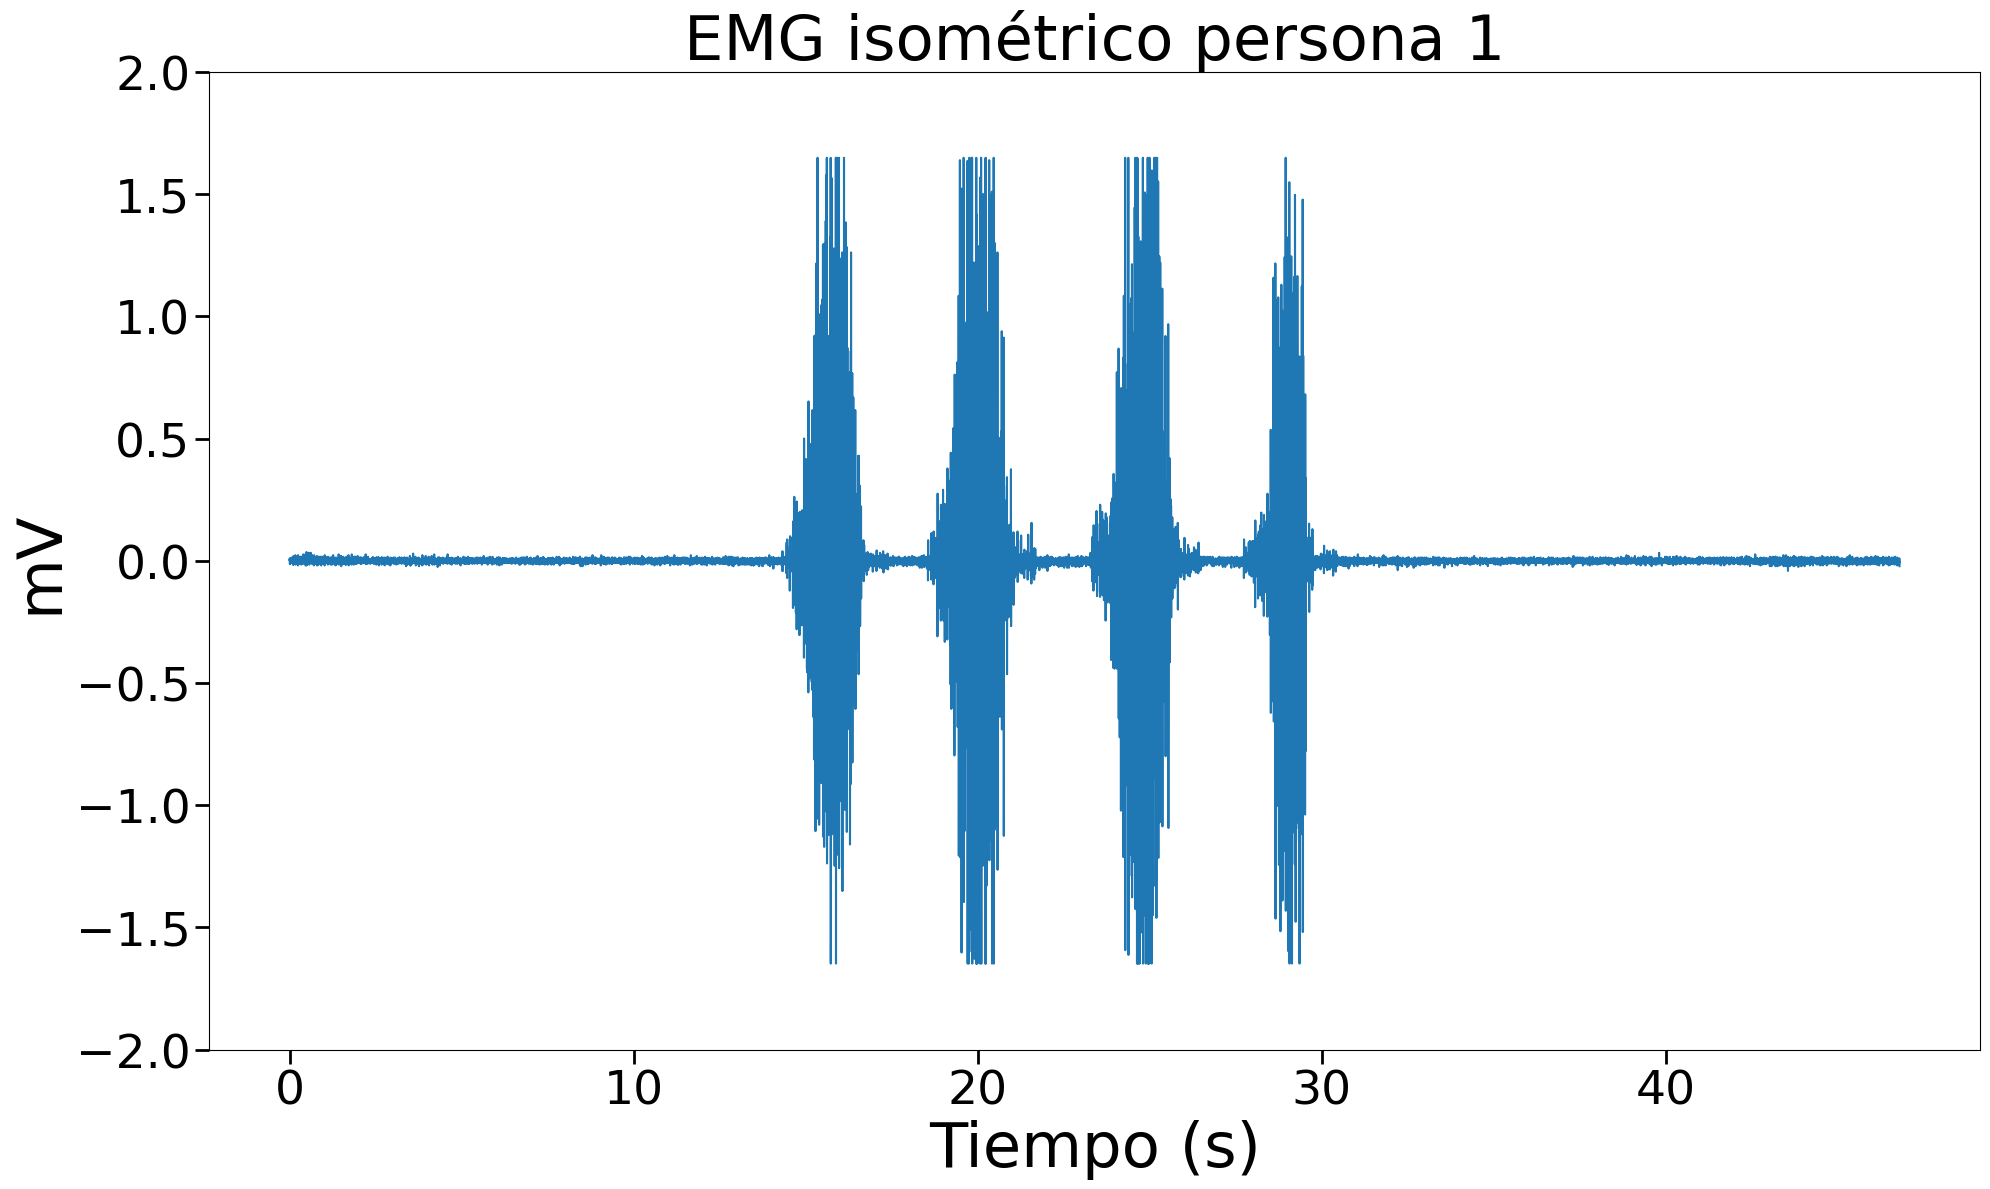

In [34]:
data=np.loadtxt("./../Laboratorio 04/emg_raw_data/isb-isometrico-armando/opensignals_98D3B1FD3DA9_2024-04-12_12-16-36.txt",skiprows=3)

# Convert bits to mV and center the signal
bits = 10  # Bits de la salida
volt_range = 3.3  # Rango de voltaje en milivoltios
data_mV = (data[:, 5] * volt_range / (2**bits - 1))  # Convertir los bits a mV
data_mV_centered = data_mV - np.mean(data_mV)  # Centrar la señal

# Rectify the signal (full-wave rectification)
data_mV_rectified = np.abs(data_mV_centered)

time = np.arange(len(data_mV))/1000 

plt.figure(figsize=(20,12))

plt.plot(time,data_mV_centered)

plt.ylim(-2, 2)
#plt.xlim(0, 31)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('EMG isométrico persona 1', fontsize=45)
plt.tight_layout()


plt.savefig("plots/isb-isometrico-armando.png")


      Mean (mV)  Standard Deviation (mV)
0      0.005461                 0.004558
1      0.005366                 0.004599
2      0.005811                 0.004762
3      0.005161                 0.004449
4      0.005525                 0.004569
...         ...                      ...
1161   0.004221                 0.003840
1162   0.004385                 0.004011
1163   0.003827                 0.003240
1164   0.004329                 0.003579
1165   0.004359                 0.003803

[1166 rows x 2 columns]


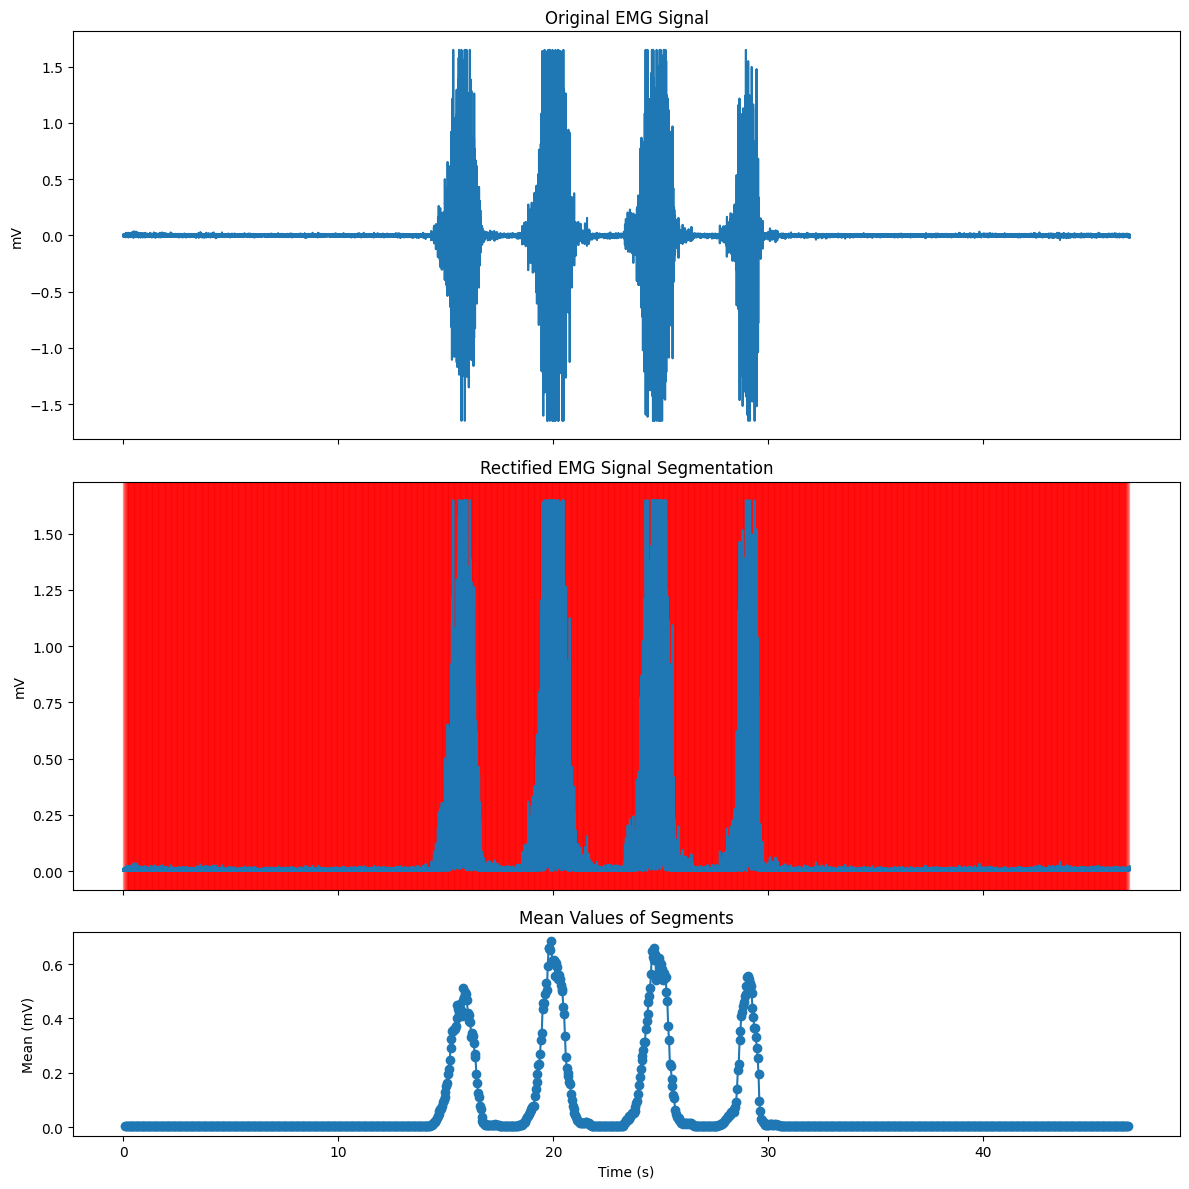

In [40]:
# Function to segment the EMG signal
def segment_signal(signal, segment_length, increment, sampling_rate):
    segment_samples = int(segment_length * sampling_rate / 1000)
    increment_samples = int(increment * sampling_rate / 1000)
    segments = []

    for start in range(0, len(signal) - segment_samples + 1, increment_samples):
        end = start + segment_samples
        segments.append(signal[start:end])
    
    return np.array(segments), segment_samples, increment_samples, np.arange(0, len(signal) - segment_samples + 1, increment_samples)

# Segment the EMG signal
segment_length = 200  # in ms
increment = 40  # in ms
sampling_rate = 1000  # Hz
segments, segment_samples, increment_samples, segment_starts = segment_signal(data_mV_rectified, segment_length, increment, sampling_rate)

# Feature extraction example (mean and standard deviation of each segment in mV)
features = []
for segment in segments:
    mean_mV = np.mean(segment)  # Already in mV
    std_dev_mV = np.std(segment)  # Already in mV
    features.append([mean_mV, std_dev_mV])

features_df = pd.DataFrame(features, columns=['Mean (mV)', 'Standard Deviation (mV)'])
print(features_df)

# Plot the segmented signal and mean values
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [2, 2, 1]})

# Plot original EMG signal
axs[0].plot(time, data_mV_centered)
axs[0].set_ylabel('mV')
axs[0].set_title('Original EMG Signal')

# Plot rectified EMG signal with segmentation
axs[1].plot(time, data_mV_rectified)
axs[1].set_ylabel('mV')
axs[1].set_title('Rectified EMG Signal Segmentation')
for start in segment_starts:
    end = start + segment_samples
    if end < len(time):  # Ensure end is within the bounds of time array
        axs[1].axvspan(time[start], time[end], color='red', alpha=0.3)

# Plot mean values
mean_times = (segment_starts + segment_samples / 2) / sampling_rate  # Midpoint of each segment
axs[2].plot(mean_times, features_df['Mean (mV)'], marker='o')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Mean (mV)')
axs[2].set_title('Mean Values of Segments')

plt.tight_layout()
plt.show()

### EMG contrafuerza

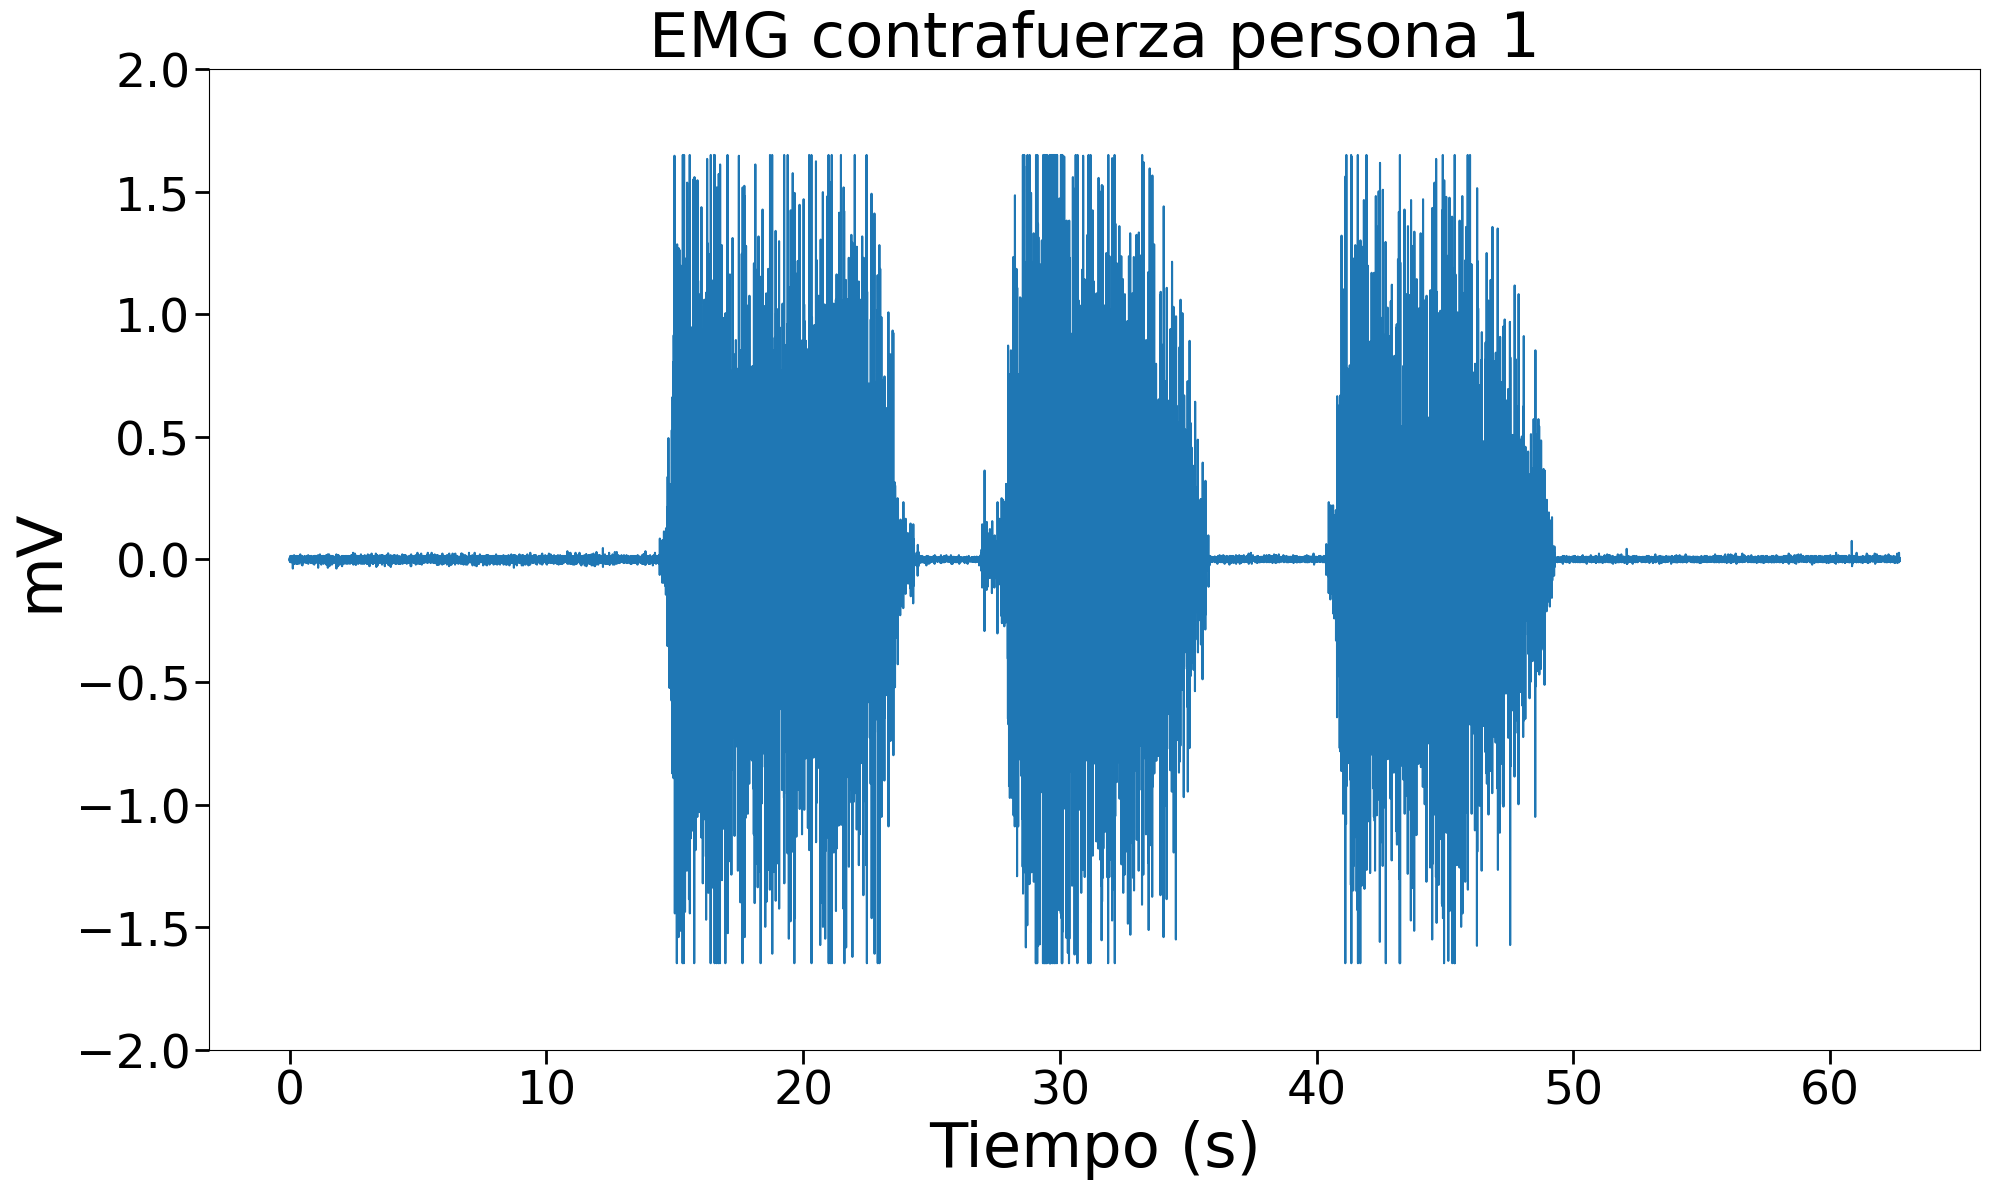

In [7]:
data=np.loadtxt("./../Laboratorio 04/emg_raw_data/isb-contrafuerza-armando/opensignals_98D3B1FD3DA9_2024-04-12_12-19-52.txt",skiprows=3)

bits = 10 # Bits de la salida 
volt_range = 3.3 #Rango de voltaje en milivoltios
data_mV = (data[:,5] * volt_range/(2**bits - 1)) # convertir los bits a mV
data_mV = data_mV - np.mean(data_mV) # Centrar la señal
time = np.arange(len(data_mV))/1000 

plt.figure(figsize=(20,12))

plt.plot(time,data_mV)

plt.ylim(-2, 2)
#plt.xlim(13, 31)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('EMG contrafuerza persona 1', fontsize=45)
plt.tight_layout()

plt.savefig("plots/isb-contrafuerza-armando.png")

#Tomamos solo 5 segundos de la señal
y_1=data_mV[15000:20000]

Fs = 1000
Ts=1/Fs # Determinar el periodo de muestreo
t_1 = np.arange(0, len(y_1)*Ts, Ts) # Crear vector de tiempo considerando periodo de muestreo

